In [16]:
import numpy as np
from numpy import random
import joblib
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score,f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score



In [2]:
train = pd.read_csv("train.csv", index_col = None)
y = train[['LABELS']]
x = train.drop('LABELS', axis=1)
xMean = x.mean()
x = x.fillna(xMean)
test_nolabels = pd.read_csv("test_nolabels.csv", index_col = None)
test_nolabels = test_nolabels.fillna(xMean)

In [ ]:
ndvi_list = {'NDVI_jan','NDVI_feb','NDVI_mar','NDVI_apr','NDVI_may','NDVI_jun','NDVI_jul','NDVI_aug','NDVI_sep','NDVI_oct','NDVI_nov','NDVI_dec'}
ndviDF = x[ndvi_list]
# ndviDF['LABELS'] = y['LABELS']
print(ndviDF.head(10))

In [3]:
toposElevation = {"topo_elevation_jan",'topo_elevation_feb','topo_elevation_mar','topo_elevation_apr','topo_elevation_may','topo_elevation_jun','topo_elevation_jul','topo_elevation_aug','topo_elevation_sep','topo_elevation_oct','topo_elevation_nov','topo_elevation_dec'}
topoSlope = {'topo_slope_jan','topo_slope_feb','topo_slope_mar','topo_slope_apr','topo_slope_may','topo_slope_aug','topo_slope_jun','topo_slope_jul','topo_slope_sep','topo_slope_oct','topo_slope_nov','topo_slope_dec'}
topoElevationDF = x[toposElevation]
topoElevationMean = topoElevationDF.mean(axis=1)
x = x.drop(toposElevation,axis=1)
x['topoElevationMean'] = topoElevationMean
topoSlopeDF = x[topoSlope]
topoSlopeMean = topoSlopeDF.mean(axis=1)
x = x.drop(topoSlope, axis=1)
x['topoSlope'] = topoSlopeMean


In [4]:
#preprocessing No_label datase:
test_nolabels = test_nolabels.fillna(xMean)
test_nolabels = test_nolabels.drop(toposElevation, axis=1)
test_nolabels = test_nolabels.drop(topoSlope, axis=1)
test_nolabels['topoElevationMean'] = topoElevationMean
test_nolabels['topoSlope'] = topoSlopeMean

In [6]:
x_train, x_validation, y_train, y_validation = train_test_split( x,y, test_size=0.2)
y_train = (np.array(y_train).astype('int')).ravel()
y_validation = (np.array(y_validation).astype('int')).ravel()


In [51]:
### Some helpers function
# To adapt the prediction to Kaggel format of submission 
def formating_prediction(predictions): 
        '''
        return de predicted classes from the hypotesis function result (sigmoid(W,X))
        @hypotesis : matrix of probablilities 
        '''
        y_hat = pd.DataFrame({'S.No' : [],'LABELS' : []}, dtype=np.int8) 
        for i in range(len(predictions)):
            y_hat.loc[i] = [i,predictions[i]]
        return pd.DataFrame(data = y_hat) 

def predictOnSet(model, x_test):
    prediction = model.predict(x_test)
    return prediction

def savingModels(classifier, modelFileName):
    '''
    NOTE: Do not forget the extention = *.pkl
    Save as : 'modelFileName.pkl'
    '''
    joblib.dump(classifier, modelFileName)


def importModel(modefname):
    model = joblib.load(modefname)
    return model

def savePrediction(prediction, filename):
    '''
    Save predictions
    @argument: filename: Remenber EXTENTION 'filename.csv'
    '''
    prediction = prediction.astype('int32') #exsure prediction as integer
    predictions_DF = formating_prediction(prediction)
    return predictions_DF.to_csv(filename, index = None)



In [40]:
## modle evaluation
def metric_RocAuc(y_probability, y_validation, estimator_name):
    '''
    Calculate and plt ROC metric
    @argument: y_probability : the probability class=1.
    @argument: y_validation: True labels.
    fpr, tpr = false_positive, true_positive.
    Return: "false_positive" and "true_positive", ROC_auc metric.
    '''
    fpr, tpr, _ = roc_curve(y_validation, y_probability) 
    roc_auc = auc(fpr, tpr)
    fig, axes = plt.subplots(constrained_layout=True,figsize=(5,3), dpi=150)
    fig.suptitle(estimator_name)
    axes.plot([0, 1], [0, 1], color= 'k',linestyle="--") # perfect fit 
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                       estimator_name=estimator_name)
    display.plot(ax=axes)
    return fpr, tpr, roc_auc

## Show some evaluation criteria on the clasifier
def evaluate_model(x_train, y_train, x_validation, y_validation, classifier):
    features = x_train.columns
    validation_Prediction = classifier.predict(x_validation)
    validation_PredictedProb = classifier.predict_proba(x_validation)[:, 1]
    ### ROC metric and curve #####
    clasifierName = type(classifier).__name__
    metric_RocAuc(validation_PredictedProb, y_validation,clasifierName)
    fi_model = pd.DataFrame({'feature': features,
                   'importance': classifier.feature_importances_}).\
                    sort_values('importance', ascending = False)
    clasifierNameExtended = clasifierName + "_info_fi"     
    fi_model.to_csv(clasifierNameExtended, index = None)
    return fi_model

In [ ]:
param_grid = {
    'n_estimators': np.linspace(10,1000,20).astype(int),
    'max_depth': [None] + list(np.linspace(3,20,8).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.2, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(5, 50,10).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = seedRF)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=seedRF)
rs.fit(x_train, y_train)
print(rs.best_params_, "\n")
best_model = rs.best_estimator_
savingModels(best_model, "rf_RandomDSEtReduced.pkl")

In [ ]:
# classifier = joblib.load("rf_RandomSearch.pkl")

classifier = RandomForestClassifier(n_estimators = 300, n_jobs = -1, criterion = 'entropy',max_depth=10,max_features=0.2,max_leaf_nodes=20,max_samples=0.7,bootstrap =True)

classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_validation)
accuracy = accuracy_score(y_validation, y_pred)
# recording[str(i)] = accuracy
print(str(i) + "_Accuracy: %.2f%%" % (accuracy))
evaluate_model(x_train, y_train, x_validation, y_validation, classifier)

In [ ]:
print(classifier.get_params(deep=True))

In [ ]:
for i in range(5):
    x_train, x_validation, y_train, y_validation = train_test_split( x,y, test_size=0.2)
    y_train = (np.array(y_train).astype('int')).ravel()
    y_validation = (np.array(y_validation).astype('int')).ravel()
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    # recording[str(i)] = accuracy
    print(str(i) + "_Accuracy: %.2f%%" % (accuracy))
    evaluate_model(x_train, y_train, x_validation, y_validation, classifier)

In [ ]:
## Cross validation:
kf = model_selection.KFold(n_splits=3, random_state=None) 
result = cross_val_score(classifier , x_validation, y_validation, cv = kf)
print(result)

In [ ]:
savingModels(classifier, "RF_400AllRandom.pkl")

test_nolabels_prediction = predictOnSet(classifier, test_nolabels)
savePrediction(test_nolabels_prediction, 'RF_400AllRandom.csv')



In [ ]:
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model,x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
model = grid_result.best_estimator_
joblib.dump(model, 'AdaBoostGrid.pkl')

In [99]:
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

model = grid_result.best_estimator_
model.fit(x_train, y_train, cla)

joblib.dump(model, 'AdaBoostGrid.pkl')
evaluate_model(x_train, y_train, x_validation, y_validation, model)

In [ ]:
model.fit(x_train, y_train)
evaluate_model(x_train, y_train, x_validation, y_validation, model)

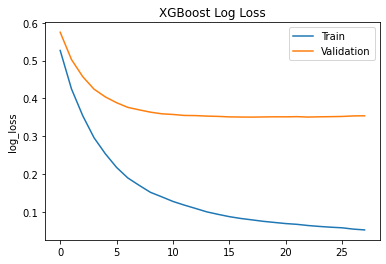

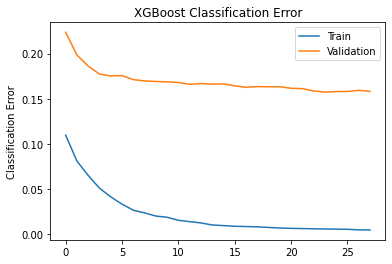

In [11]:
# model = joblib.load('XGBClassifierGridSearh.pkl')

### ploting the model behavior on train and validation datasets over epochs
eval_set = [(x_train, y_train),(x_validation, y_validation)]
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

results = model.evals_result()

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
pyplot.ylabel('log_loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Validation')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [25]:
# Calculating F1 metrics for all produced models
modelNameList =  ['XGBClassifierGridSearh.pkl']

for modelName in modelNameList:
    model = joblib.load(modelName)
    model.fit(x_train, y_train) 
    y_hat = model.predict(x_validation)
    f1 = f1_score(y_validation, y_hat)
    roc = roc_auc_score(y_validation, y_hat)
    print("Metrics of model  " + modelName + ": f1_score =", f1, ", ROC = ", roc,"\n",)
        


[23:10:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:10:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Metrics of model  XGBClassifierGridSearh.pkl: f1_score = 0.8886356821589205 , ROC =  0.8255494825318106 

